Recall the form of **exponential family**:
$$f(y) = \exp\left(\frac{\theta y - b(\theta)}{\alpha(\phi)} + c(y,\phi)\right),$$
- $\theta$ is called canonical parameter,
- $\alpha,b,c$ are known functions,
- $\phi$ is dispersion.

This implies the log-likelihood for $\{y_1,...,y_n\}$ is:
$$\ell = \sum_{i=1}^{n}\ell_i = \sum_{i=1}^{n}\left(\frac{\theta y_i - b(\theta)}{\alpha(\phi)} + c(y_i,\phi)\right).$$

- *Question: What assumption did we make?*

Note that each score function is:
$$s_i = \frac{\partial l_i}{\partial \theta} = \frac{y_i - b'(\theta)}{\alpha(\phi)}$$

This implies $\mathbb{E}(Y) = b'(\theta)$ and $\text{Var}(Y) = \alpha(\phi)b''(\theta)$.
- *Question: Why $\mathbb{E}(Y) = b'(\theta)$*
- *Exercise: Show $\text{Var}(Y) = \alpha(\phi)b''(\theta)$*

How do we estimate the parameter $\theta$ through MLE?
$$ \sum_{i=1}^n s_i = \sum_{i=1}^n \frac{\partial \mathbb{E}(Y_i)}{\partial \theta} \frac{Y_i - \mathbb{E}(Y_i)}{\text{Var}(Y)} = 0.$$

In the context of GLM:
$$\mathbb{E}(Y_i) = \mu_i = g^{-1}(x_i^T \beta), \quad \text{Var}(Y_i) = V(\mu_i).$$

For example, in **linear regression**, we have:
$$\mu_i = x_i^T \beta, \quad V(\mu_i) = \sigma^2.$$

- $g$ is identity function,
- $V$ is a constant function.

For **binary** data, we can use logistic model:
$$\mu_i = \exp(x_i^T \beta)/(1+\exp(x_i^T \beta)), \quad V(\mu_i) = \mu_i(1-\mu_i).$$

- $g(p) = \log\left(\frac{p}{1-p}\right)$ (logit link function)
- $V$ is based on Bernoulli distribution.

For **Poisson** data, we can use log-linear model:
$$\mu_i = \exp(x_i^T \beta), \quad V(\mu_i) = \mu_i.$$

- $g(\lambda) = \log(\lambda)$ (log-link function)
- $V$ is a linear function of $\mu_i$

Our target is to estimate $\beta$:

$$\sum_{i=1}^n \frac{y_i - \mu_i}{V(\mu_i)g'(\mu_i)}x_i = 0$$

- This is a nonlinear equation of $\beta$.
- The solution $\hat{\beta}$ has no explicit form.
- We can iteratively estimate $\hat{\beta}^{(k)}$.

Let's use the **Fisher Scoring** Algorithm:
$$ \hat{\beta}^{(k+1)} = \hat{\beta}^{(k)} + I^{-1}(\hat{\beta}^{(k)})S(\hat{\beta}^{(k)}),$$
with some tedious algebra, we can show:
$$ \hat{\beta}^{(k+1)} = (X^TW^{(k)}X)^{-1}X^TW^{(k)}z^{(k)}, \quad (*)$$
- $X$ is design matrix,
- $W^{(k)}$ is a diagonal matrix with $W^{(k)}_{ii} = \frac{1}{V(\hat{\mu}_i^{(k)})[g' (\hat{\mu}_i^{(k)}) ]}$
- $z^{(k)} = x_i^T\hat{\beta}^{(k)} + g'(\hat{\mu}_i^{(k)}) (y_i - \hat{\mu}_i^{(k)}).$

Note that $(*)$ can be viewed as the solution to:
$$\arg \min_{\beta} \sum_{i=1}^n W_{ii}^{(k)} (z_i^{(k)} - x_i^T \beta)^2,$$
- This is just another least square problem!
- Only difference is now the square is weighted.


For this reason, this algorithm is called **Iterative Reweighted Least Square (IRLS)**:

1. We start with an inital value $\hat{\beta}^{(0)}$.
2. Compute the new response variable $z^{(0)}$ and the new weight $W^{(0)}$
3. Solve the weighted Least Square for $\hat{\beta}^{(1)}$
4. Keep repeating 2 and 3 until converge

*Question: If we want to solve $\hat{\beta}$ from the above algorithm, do we need the full exponential family form?*

Not really... We just need the score equation:
$$ \sum_{i=1}^n s_i = \sum_{i=1}^n \frac{\partial \mu_i}{\partial \beta} \frac{Y_i - \mu_i}{V(\mu_i)} = 0.$$

We can define a **quasi-likelihood** (maybe better called quasi-log-likelihood) function $q(\mu_i)$ such that $\frac{\partial q(\mu_i)}{\partial \mu_i} = \frac{y_i - \mu_i}{V(\mu_i)}$.

Let $$\psi_i = \frac{\partial q(\mu_i)}{\partial \beta} = \frac{\partial q(\mu_i)}{\partial \mu_i} \frac{\partial \mu_i}{\partial \beta} = \frac{y_i - \mu_i}{V(\mu_i)} \frac{1}{g'(\mu_i)}$$
this implies that
$$\sum_{i=1}^n \psi_i = 0 ⇒ \sum_{i=1}^n\frac{y_i - \mu_i}{V(\mu_i)} \frac{1}{g'(\mu_i)} = 0.$$


- There is no problem of using IRLS to solve this.
- We **do not** need to know the distribution of $Y_i$
- We just need to specify the relationship between variance and mean through $V(\mu)$
- Of course we still need to know the link function $g$...

Let's look at this problem for a simple Poisson model:


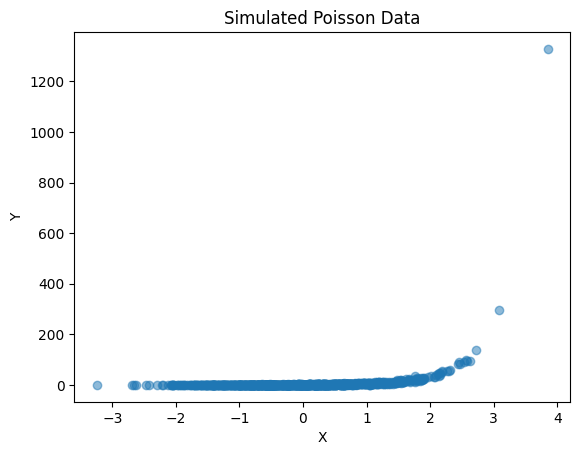

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)
n = 1000; # sample size

# Generate predictor variable X
X = np.random.normal(0, 1, n)

# Generate weights for simulation
beta_0 = -0.5  # Intercept
beta_1 = 2.0   # Slope

# Calculate rate using exp function
rate = np.exp(beta_0 + beta_1*X)

# Generate Poisson variable Y
Y = np.random.poisson(rate)

plt.scatter(X, Y, alpha=0.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Simulated Poisson Data')
plt.show()

In [21]:
def poisson_regression_irls(X, Y, max_iterations=100):
    # Add intercept
    X = np.column_stack((np.ones(X.shape[0]), X))

    # Initial guess for the parameters
    beta = np.zeros(X.shape[1])

    for iteration in range(max_iterations):
        # Calculate current mu
        rate = np.exp(np.dot(X, beta))

        # Update the weight matrix
        W = np.diag(rate)

        # Update the response variable
        Z = np.dot(X, beta) + (Y-rate)/rate

        # Update beta through weighted least squares
        beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, np.dot(W, X))), X.T), np.dot(W, Z))

    return beta

Let's visualize its convergence:

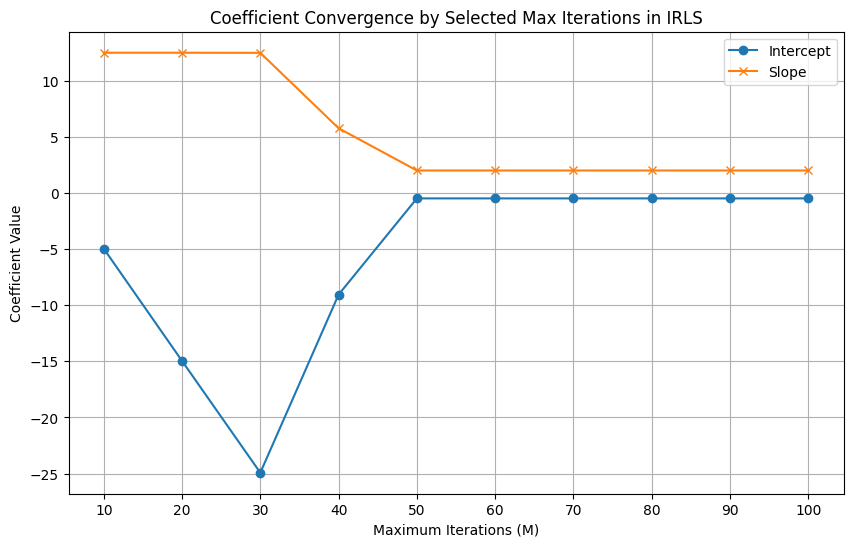

In [19]:
final_betas_selected = np.zeros((10, 2))  # 10 selected settings for M, 2 coefficients (intercept and slope)
Ms_selected = np.arange(10, 101, 10)  # M values

for i, M in enumerate(Ms_selected):
    beta_estimate = poisson_regression_irls(X, Y, max_iterations=M)
    final_betas_selected[i, :] = beta_estimate

# Plotting the final coefficient values for the selected max_iteration settings
plt.figure(figsize=(10, 6))
plt.plot(Ms_selected, final_betas_selected[:, 0], label='Intercept', marker='o')
plt.plot(Ms_selected, final_betas_selected[:, 1], label='Slope', marker='x')
plt.xlabel('Maximum Iterations (M)')
plt.ylabel('Coefficient Value')
plt.title('Coefficient Convergence by Selected Max Iterations in IRLS')
plt.xticks(Ms_selected)
plt.legend()
plt.grid(True)
plt.show()

In [20]:
beta_estimate

array([-0.49363234,  1.99136679])

***Question***: Why the results are not converging to the true values? ($\beta_0 = -0.5$, $\beta_1 = 2$)